imports
matplotlib is for visualization. in actual opencv use: 
cv2.imshow("name", image)

In [1]:
import cv2 #opencv
import numpy as np
import matplotlib.pyplot as plt

read and process image

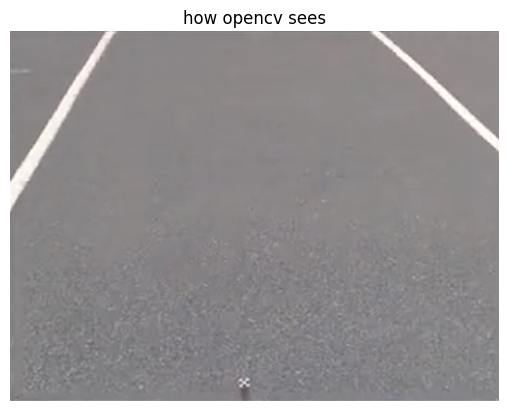

In [110]:
image = cv2.imread('test_image4.png')
image = np.copy(image) #to np

plt.figure()
plt.title("how opencv sees")
plt.imshow(image)
plt.axis("off")
plt.show()

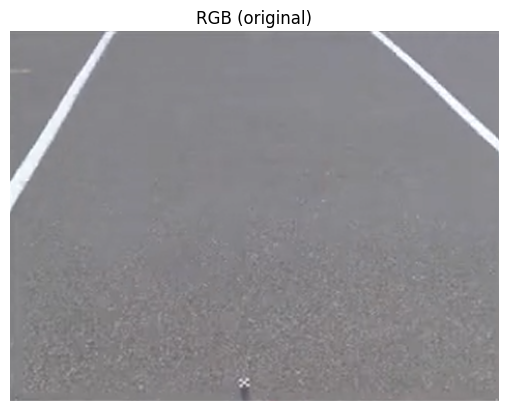

In [111]:
img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure()
plt.title("RGB (original)")
plt.imshow(img_rgb)
plt.axis("off")
plt.show()

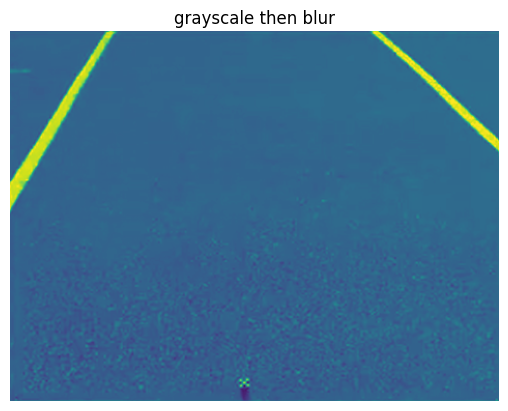

In [112]:
gray = cv2.cvtColor(img_rgb,cv2.COLOR_RGB2GRAY) #grayscale of ORIGINAL
blur = cv2.GaussianBlur(gray,(5,5),0) #blur for noise reduction

plt.figure()
plt.title("grayscale then blur")
plt.imshow(gray)
plt.axis("off")
plt.show()


optional fourier pipeline step

In [113]:
f = np.fft.fft2(gray) #2D fourier transform
fshift = np.fft.fftshift(f) #fourier shift (values at corners to the centre)
magnitude_spectrum = 20*np.log(np.abs(fshift))
 
# plt.figure()
# plt.title("fft magnitude")
# plt.imshow(magnitude_spectrum)
# plt.axis("off")
# plt.show()

rows, cols = gray.shape
crow, ccol = rows // 2, cols // 2

mask = np.ones((rows, cols), np.uint8)
r = 30  # cutoff radius (tune this)
cv2.circle(mask, (ccol, crow), r, 0, -1)
 
fshift_hp = fshift * mask

f_ishift = np.fft.ifftshift(fshift_hp)
img_ifft = np.fft.ifft2(f_ishift)
img_ifft = np.abs(img_ifft)

# plt.figure()
# plt.title("img after inverse fft")
# plt.imshow(img_ifft)
# plt.axis("off")
# plt.show()

canny edge detection

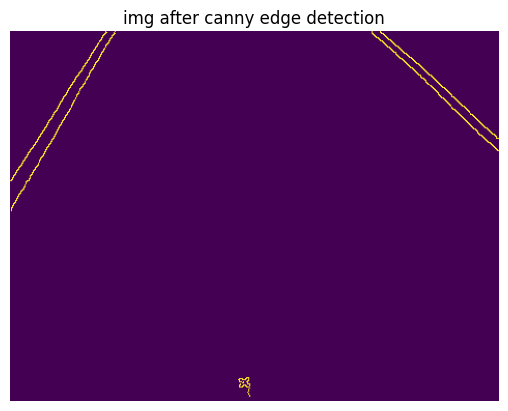

In [114]:

canny = cv2.Canny(blur, 50, 150)

# img_hp = cv2.normalize(img_ifft, None, 0, 255, cv2.NORM_MINMAX)
# img_hp = img_hp.astype(np.uint8)
# canny = cv2.Canny(img_hp, 50, 150)

plt.figure()
plt.title("img after canny edge detection")
plt.imshow(canny)
plt.axis("off")
plt.show()

fourier transform (potential alternative to canny edge detection)

In [115]:
def mask(image, bottom=0, horizon=int(image.shape[0]/2), mid=int(image.shape[1]/2)):
    polygons = np.array([[(bottom,image.shape[0]), (image.shape[1], image.shape[0]), (mid,horizon)]])
    mask = np.zeros_like(image)
    cv2.fillPoly(mask,polygons,255)
    plt.figure()
    plt.title("mask")
    plt.imshow(mask)
    plt.axis("off")
    plt.show()
    masked_image = cv2.bitwise_and(image,mask)
    return masked_image

In [116]:
def mask_for_test(image, horizon=int((image.shape[0])*4/5)):
    mask = np.zeros_like(image)

    mask[0:horizon, :] = 255

    plt.figure()
    plt.title("mask")
    plt.imshow(mask)
    plt.axis("off")
    plt.show()
    masked_image = cv2.bitwise_and(image,mask)
    return masked_image

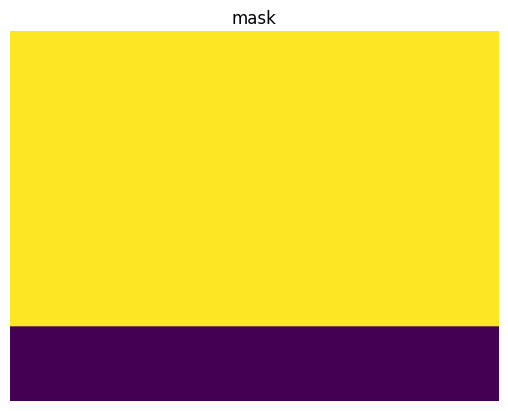

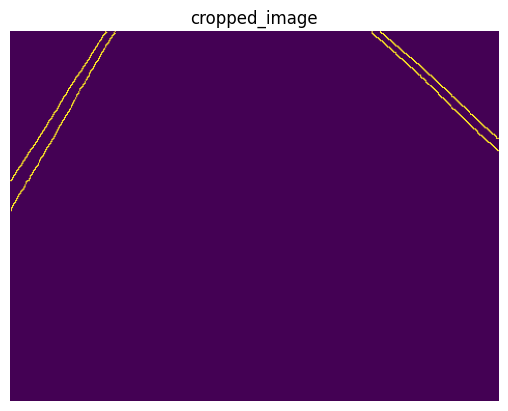

In [117]:
cropped_image = mask_for_test(canny)#mask(canny, 0, 250, int(canny.shape[1]/2)) #input bottom of view and horizon

plt.figure()
plt.title("cropped_image")
plt.imshow(cropped_image)
plt.axis("off")
plt.show()

In [118]:
def display_lines(image, lines):
    line_image = np.zeros_like(image)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line.reshape(4)
            cv2.line(line_image,(x1, y1), (x2, y2), (0, 255 , 255), 10)
    return line_image

In [119]:
#code from https://www.geeksforgeeks.org/machine-learning/opencv-real-time-road-lane-detection/
def make_coordinates(image,line_parameters):
    slope,intercept = line_parameters
    y1 = image.shape[0]
    y2 = int(y1*(3/5))
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    return np.array([x1,y1,x2,y2])
def average_slope_intercept(image,lines):
    left_fit = []
    right_fit = []
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        slope = parameters[0]
        intercept = parameters[1]
        if slope < 0:
            left_fit.append((slope,intercept))
        else:
            right_fit.append((slope,intercept))
    left_fit_average = np.average(left_fit,axis = 0)
    right_fit_average = np.average(right_fit,axis = 0)
    left_line = make_coordinates(image,left_fit_average)
    right_line = make_coordinates(image,right_fit_average)
    return np.array([left_line,right_line])

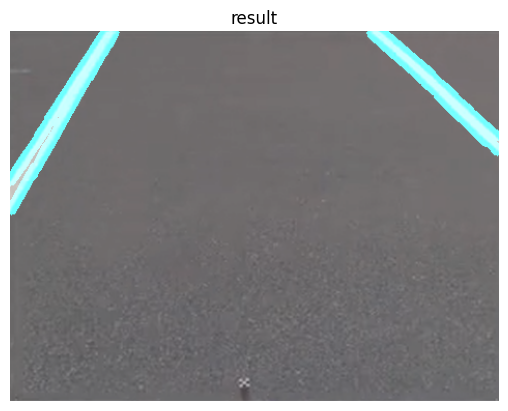

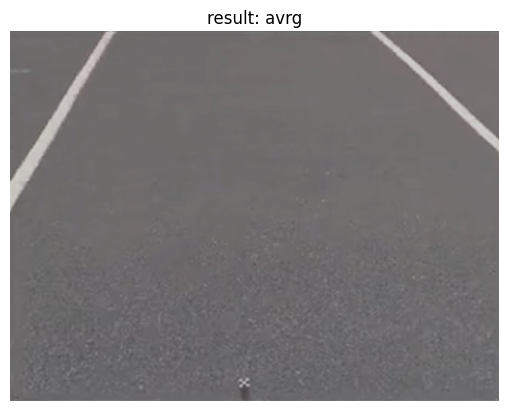

In [120]:
lines = cv2.HoughLinesP(cropped_image, 2, np.pi/180, 10, np.array([]), minLineLength = 4, maxLineGap = 5)
line_image1 = display_lines(image, lines)
result1 = cv2.addWeighted(image, 0.8, line_image1, 1, 1)
averaged_lines = average_slope_intercept(image,lines)
line_image2 = display_lines(image, averaged_lines)
result2 = cv2.addWeighted(image, 0.8, line_image2, 1, 1)

plt.figure()
plt.title("result")
plt.imshow(result1)
plt.axis("off")
plt.show()

plt.figure()
plt.title("result: avrg")
plt.imshow(result2)
plt.axis("off")
plt.show()


